In [280]:
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_squared_error



In [156]:
# read data
df = pd.read_csv('data/training_jumlah_penumpang_tj.csv', sep=';')

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   bulan             108 non-null    int64
 1   tahun             108 non-null    int64
 2   jumlah_penumpang  108 non-null    int64
dtypes: int64(3)
memory usage: 2.7 KB


In [158]:
def add_date_column(data, year_col_name, month_col_name, day_col_name):
    data['year'] = data[year_col_name]
    data['month'] = data[month_col_name]
    data['day'] = data[day_col_name]
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

    return data

In [159]:
df = df.assign(hari=1)
df = add_date_column(df, 'tahun', 'bulan', 'hari')
df['date'] = pd.to_datetime(df['date'])
df.head()

,bulan,tahun,jumlah_penumpang,hari,year,month,day,date
0,1,2015,8738599,1,2015,1,1,2015-01-01
1,2,2015,7630313,1,2015,2,1,2015-02-01
2,3,2015,9383835,1,2015,3,1,2015-03-01
3,4,2015,8832441,1,2015,4,1,2015-04-01
4,5,2015,9035420,1,2015,5,1,2015-05-01


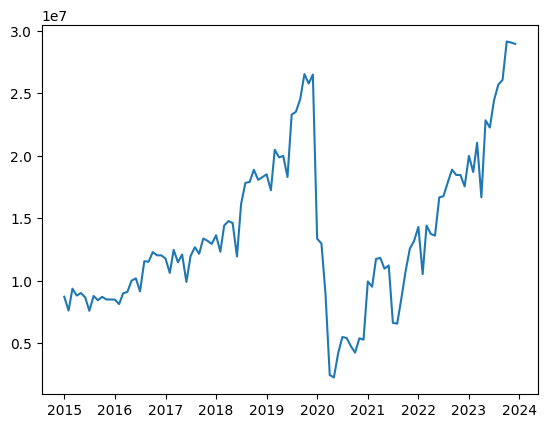

In [160]:
plt.plot(df['date'], df['jumlah_penumpang'])


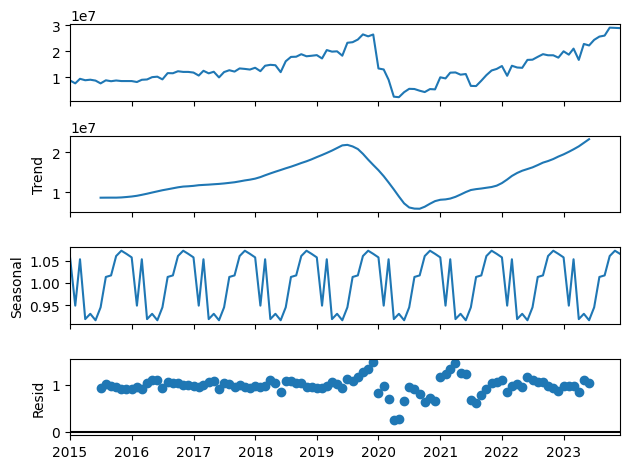

In [161]:
# cek seasonality, trend dan residual
df_analysis = df[:]
df_analysis.set_index('date', inplace=True)
analysis = df_analysis[['jumlah_penumpang']].copy()

# multiplicative is selected because there's increasing mean and seasonality
decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();


- there's anomaly in early 2020, which we know as covid pandemic. we try to use dummy variable to take account this phenomenon by assigning 1 if the periods is in covid era and 0 if it's not.
- there's maybe a seasonality pattern where the number of passengers dropped to lowest in mid year. we know that in mid year there's a long holiday (libur semester), and when there's long holiday, jakarta's people usually goes to holiday outside the city so the passenger in this period is dropped.
- The data has changing mean, meaning it is non stationary time series case.
- Because we use dummy variable as exogenouse variable, we need to use model that can handle exogenous case.

In [162]:
covid_start = datetime(2020, 3, 1) #'2020-03-01'
covid_end = datetime(2023, 5, 1) #'2023-05-01'
seasonal_n = 6

In [163]:
def add_dummy_covid(row, covid_start, covid_end):
    if row['date'] < covid_start or row['date'] > covid_end :
        val = 0
    else:
        val = 1
    return val

In [164]:
df['covid_dummy'] = df.apply(lambda x: add_dummy_covid(x, covid_start, covid_end), axis=1)

In [165]:
# data before we doesn't have covid
df[(df['date'] < covid_start) | (df['date']  > covid_end)]

,bulan,tahun,jumlah_penumpang,hari,year,month,day,date,covid_dummy
0,1,2015,8738599,1,2015,1,1,2015-01-01,0
1,2,2015,7630313,1,2015,2,1,2015-02-01,0
2,3,2015,9383835,1,2015,3,1,2015-03-01,0
3,4,2015,8832441,1,2015,4,1,2015-04-01,0
4,5,2015,9035420,1,2015,5,1,2015-05-01,0
...,...,...,...,...,...,...,...,...,...
103,8,2023,25693459,1,2023,8,1,2023-08-01,0
104,9,2023,26076085,1,2023,9,1,2023-09-01,0
105,10,2023,29146729,1,2023,10,1,2023-10-01,0
106,11,2023,29062581,1,2023,11,1,2023-11-01,0


In [166]:
# data when we have covid
df[(df['date'] >= covid_start) & (df['date']  <= covid_end)].head()

,bulan,tahun,jumlah_penumpang,hari,year,month,day,date,covid_dummy
62,3,2020,9015000,1,2020,3,1,2020-03-01,1
63,4,2020,2481000,1,2020,4,1,2020-04-01,1
64,5,2020,2282000,1,2020,5,1,2020-05-01,1
65,6,2020,4228000,1,2020,6,1,2020-06-01,1
66,7,2020,5515000,1,2020,7,1,2020-07-01,1


In [167]:
# split data
df_train_test = df.copy()
df_train_test.set_index('date', inplace=True)
test_split=round(len(df)*0.04)
df_train=df_train_test[:-test_split]
df_test=df_train_test[-test_split:]
print(df_train.shape)
print(df_test.shape)

(104, 8)
(4, 8)


In [168]:
df_train.tail()

,bulan,tahun,jumlah_penumpang,hari,year,month,day,covid_dummy
date,,,,,,,,
2023-04-01,4,2023,16686971,1,2023,4,1,1
2023-05-01,5,2023,22845144,1,2023,5,1,1
2023-06-01,6,2023,22264954,1,2023,6,1,0
2023-07-01,7,2023,24428349,1,2023,7,1,0
2023-08-01,8,2023,25693459,1,2023,8,1,0


In [169]:

model = SARIMAX(df_train['jumlah_penumpang'], exog=df_train[['covid_dummy']], order=(1, 1, 1), seasonal_order=(1, 1, 1, seasonal_n))

model_fit = model.fit()
print(model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51584D+01    |proj g|=  4.96897D-02
                                     SARIMAX Results                                     
Dep. Variable:                  jumlah_penumpang   No. Observations:                  104
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood               -1574.695
Date:                           Wed, 31 Jul 2024   AIC                           3161.390
Time:                                   22:24:53   BIC                           3176.838
Sample:                               01-01-2015   HQIC                          3167.637
                                    - 08-01-2023                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P

/Users/fikrianggara/Projects/indathon-round1-2024/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/fikrianggara/Projects/indathon-round1-2024/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [170]:
df_train_test['fitted'] = model_fit.fittedvalues


<Axes: xlabel='date'>

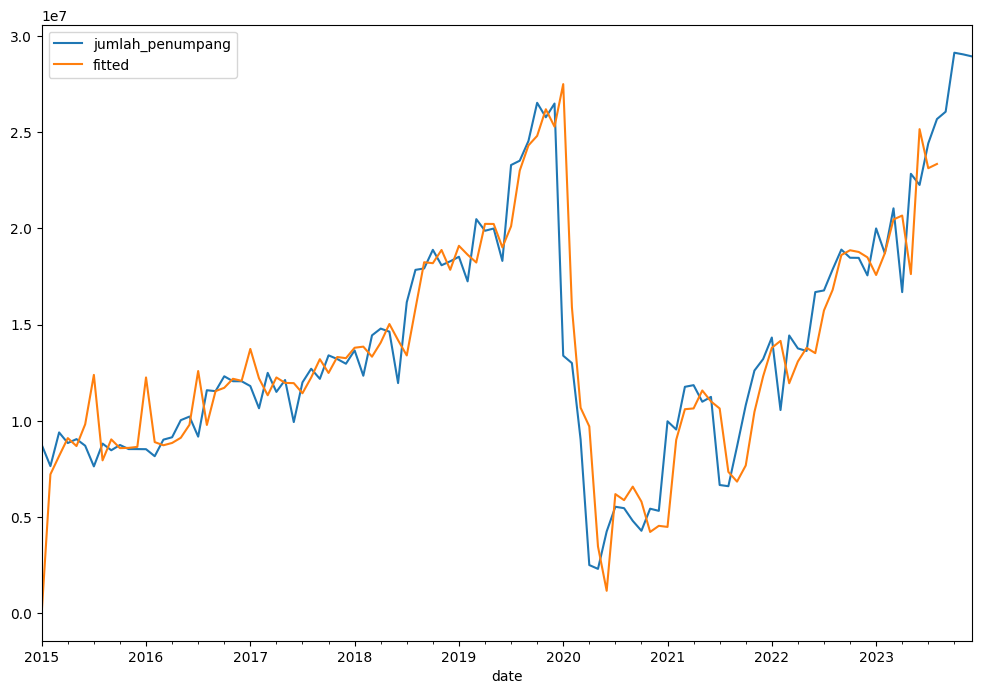

In [171]:
df_train_test[['jumlah_penumpang', 'fitted']].plot(figsize=(12, 8))

In [172]:
df_train.tail()

,bulan,tahun,jumlah_penumpang,hari,year,month,day,covid_dummy
date,,,,,,,,
2023-04-01,4,2023,16686971,1,2023,4,1,1
2023-05-01,5,2023,22845144,1,2023,5,1,1
2023-06-01,6,2023,22264954,1,2023,6,1,0
2023-07-01,7,2023,24428349,1,2023,7,1,0
2023-08-01,8,2023,25693459,1,2023,8,1,0


/var/folders/c1/h3nnk0c16j75s9z5w3kz92cw0000gn/T/ipykernel_19428/3090184887.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df_test.index[-1], periods=forecast_steps + 1, freq='M')[1:]


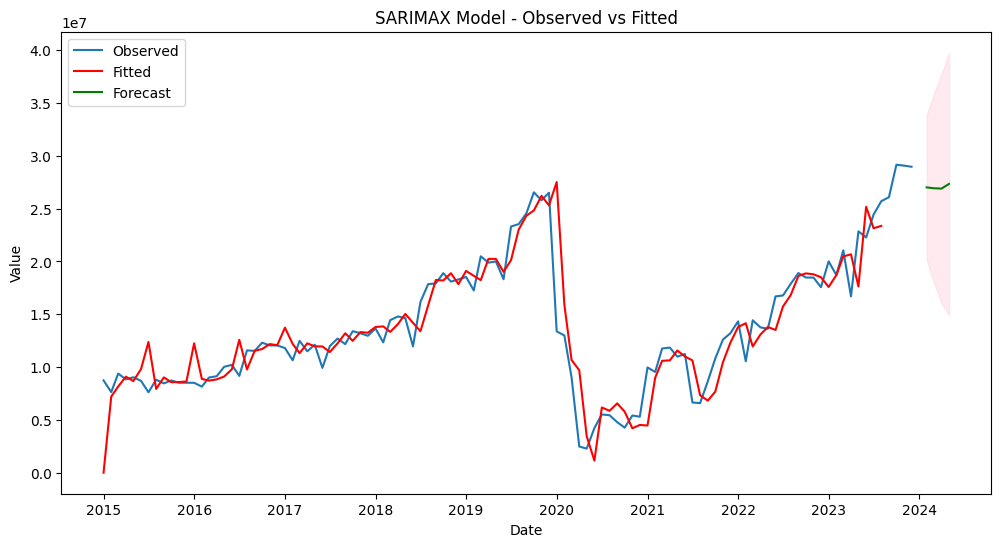

In [173]:
forecast_steps = test_split
forecast = model_fit.get_forecast(steps=forecast_steps, exog=df_test[['covid_dummy']])
forecast_index = pd.date_range(start=df_test.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Extract predicted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

df_train_test

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df_train_test.index, df_train_test['jumlah_penumpang'], label='Observed')
plt.plot(df_train_test.index, df_train_test['fitted'], color='red', label='Fitted')
plt.plot(forecast_index, forecast_mean, color='green', label='Forecast')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMAX Model - Observed vs Fitted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

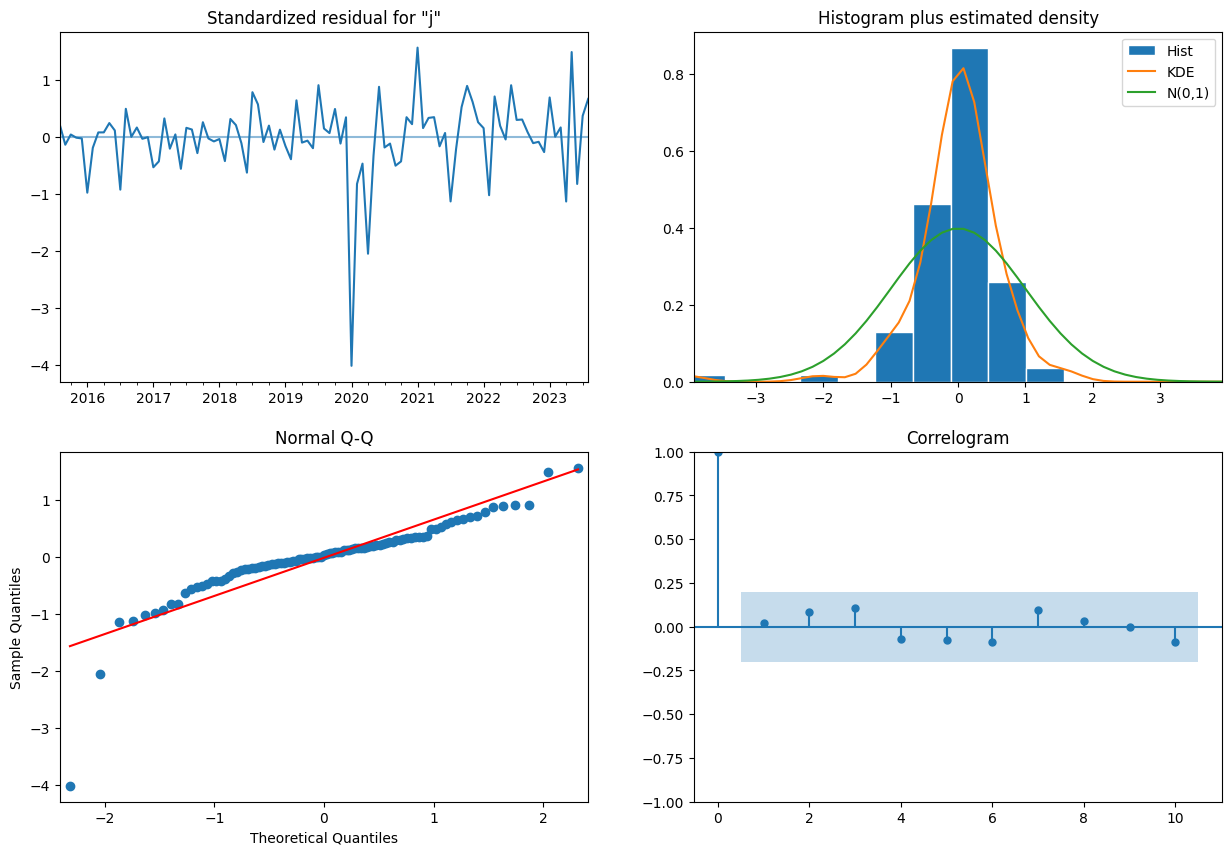

In [174]:
model_fit.plot_diagnostics(figsize=(15, 10))
plt.show()

In [175]:
rmse = np.sqrt(mean_squared_error(df_test['jumlah_penumpang'], forecast_mean))
rmse

np.float64(1814528.445995928)

# Utility Function

In [ ]:

#  function to add date column
#  require
#  - data, a dataframe
#  - year_col_name, a string of year column name
#  - month_col_name, a string of month column name
#  - day_col_name, a string of day column name

def add_date_column(data, year_col_name, month_col_name, day_col_name):
    data['year'] = data[year_col_name]
    data['month'] = data[month_col_name]
    data['day'] = data[day_col_name]
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

    return data

# function to add dummy column for covid
# require
# - data, a dataframe
# - covid_start, a datetime
# - covid_end, a datetime
def add_dummy_covid(row, covid_start=datetime(2020, 3, 1), covid_end=datetime(2023, 5, 1)):
    if row['date'] < covid_start or row['date'] > covid_end :
        val = 0
    else:
        val = 1
    return val

# function to set date as index
# require
# - data, a dataframe
# - date_col_name, a string of date column name
def set_date_as_index(data, date_col_name):
    data.set_index(date_col_name, inplace=True)
    return

# function to create model, return model.fit() from SARIMAX object
# require 
# - target_col_train, a one dimensional dataframe of target column values that has date as the index;
# - exog, a dataframe of exogenous variable values that has date as the index
def create_model(target_col_train, exog):
    model = SARIMAX(target_col_train, exog=exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 6))
    return model.fit()

# function to forecast forecast_steps amount
# require
# - model, a SARIMAX object
# - forecast_steps, an integer of forecast steps
# - exog, a dataframe of exogenous variable values that has date as the index
def forecast(model, forecast_steps, exog):
    forecast = model.get_forecast(steps=forecast_steps, exog=exog)
    return forecast

# function that return dataframe of predicted values which has the same form as submission.csv data
# require
# - predictions, a prediction object from SARIMAX.get_forecast
def create_output_df(predictions):

    res = {
        'id':np.arange(1, len(predictions.predicted_mean) + 1),
        'jumlah_penumpang': predictions.predicted_mean,
    }
    df = pd.DataFrame(res)
    df.index = np.arange(1, len(predictions.predicted_mean) + 1)
    return df

# function to save dataframe to csv
def save_to_csv(df, filename):
    df.to_csv(filename, sep=',',index=False)
    print('prediction saved to csv file: {}'.format(filename))

# main function
# require
# - target_col_train, a one dimensional dataframe of target column values that has date as the index;
# - exog, a dataframe of exogenous variable values that has date as the index
# - forecast_steps, an integer of forecast steps in months
# - filename, a string of filename
def forecast_and_save_to_csv(forecast_steps, start_date, filename):
    
    df = pd.read_csv('data/training_jumlah_penumpang_tj.csv', sep=';')
    df = df.assign(hari=1)
    df = add_date_column(df, 'tahun', 'bulan', 'hari')
    df['covid_dummy'] = df.apply(add_dummy_covid, axis=1)
    set_date_as_index(df, 'date')

    target_col_train = df['jumlah_penumpang']
    exog = df[['covid_dummy']]
    model = create_model(target_col_train, exog)

    prediction_exog = pd.DataFrame({
        'covid_dummy': [0 for x in range(0, forecast_steps)]
    })
    end_date = start_date + pd.DateOffset(months=forecast_steps)
    date_range = pd.date_range(start_date, end_date, freq='M')
    prediction_exog.set_index(date_range, inplace=True)

    predictions = forecast(model, forecast_steps, prediction_exog['covid_dummy'])

    df = create_output_df(predictions)
    
    save_to_csv(df, filename)


# Forecasting Final

In [176]:
model = SARIMAX(df_train_test['jumlah_penumpang'], exog=df_train_test[['covid_dummy']], order=(1, 1, 1), seasonal_order=(1, 1, 1, seasonal_n))

model_fit = model.fit()
print(model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52006D+01    |proj g|=  4.47677D-02

At iterate    5    f=  1.51850D+01    |proj g|=  1.25035D-03

At iterate   10    f=  1.51849D+01    |proj g|=  2.26269D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     14      1     0     0   7.020D-07   1.518D+01
  F =   15.184922747812932     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                  

/Users/fikrianggara/Projects/indathon-round1-2024/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/fikrianggara/Projects/indathon-round1-2024/env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


In [191]:
df_submission = pd.read_csv('data/testing_jumlah_penumpang_tj.csv', sep=';')
# set covid_dummy as 0 since we know that there's no covid
df_submission['covid_dummy'] = 0
forecast_steps = len(df_submission)
forecast = model_fit.get_forecast(steps=forecast_steps, exog=df_submission[['covid_dummy']])


In [192]:
forecast.predicted_mean

2024-01-01    2.930771e+07
2024-02-01    2.863549e+07
2024-03-01    3.024137e+07
2024-04-01    2.911139e+07
2024-05-01    3.037656e+07
2024-06-01    3.017594e+07
Freq: MS, Name: predicted_mean, dtype: float64

In [179]:
res = {
    'id':np.arange(1, len(forecast.predicted_mean) + 1),
    'jumlah_penumpang': forecast.predicted_mean,
}
df_final = pd.DataFrame(res)
df_final.index = np.arange(1, len(forecast.predicted_mean) + 1)

In [180]:
df_final

,id,jumlah_penumpang
1,1,2.930771e+07
2,2,2.863549e+07
3,3,3.024137e+07
4,4,2.911139e+07
5,5,3.037656e+07
6,6,3.017594e+07


In [181]:
df_final.to_csv('data/submission.csv', sep=',',index=False)